In [2]:
# Intentionally Left blank

In [3]:
#Lets mount the drive first.
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/capstone')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




## **1. Import the  required packages**



In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

In [5]:
# Read the dataframe
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/capstone/sample30.csv')

In [6]:
#Check the top 5 records in the dataframe.
df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [7]:
#Check the dataframe shape
df.shape

(30000, 15)

In [8]:
#Checking the null values count for each column
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [9]:
#Checking the dataframe column information
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


In [10]:
# As we only have "reviews_rating" column in integer, lets check out its statistics values.
df.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [11]:
# This will show how many records counts are available against each rating number.
df['reviews_rating'].value_counts() 

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

In [12]:
# This will display the count of "user_sentiments" data.
df['user_sentiment'].value_counts() 

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

## **EDA**

In [13]:
# This will show if "user_sentiment" column having NULL values.
df[df['user_sentiment'].isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


- Imputation
  -This is a Positive user_sentiment, so lets update/impute the values as positive

In [14]:
# we are imputing "user_sentiment" as positive, because "review_text" is all positive and good.
df.at[28354,'user_sentiment']='Positive'

In [15]:
#check the record again, if we have filled the null value successfully:
df[df['user_sentiment'].isna()]
#we are not getting any null values.

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment


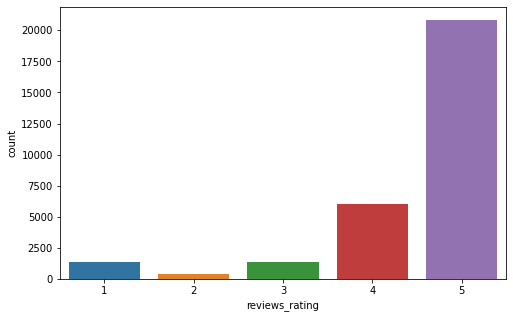

In [16]:
# A chart showing review counts and rating
plt.figure(figsize=(8,5))
ax = sns.countplot(x='reviews_rating', data=df)

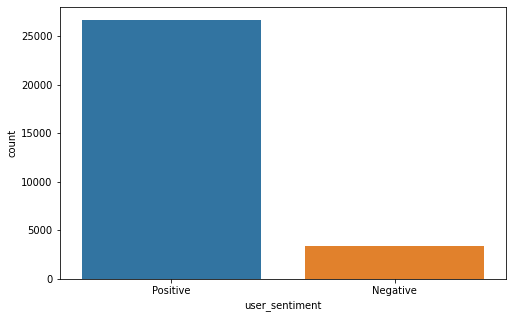

In [17]:
# A chart to show user_sentiment distribution
plt.figure(figsize=(8,5))
ax = sns.countplot(x='user_sentiment', data=df)

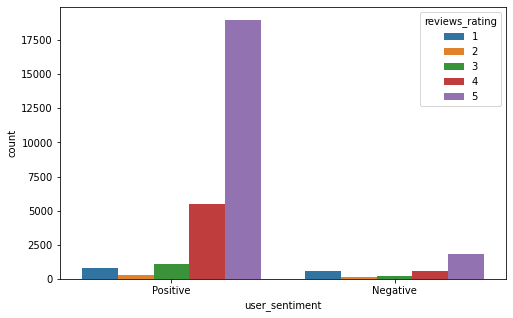

In [18]:
# A chart to showcase user_sentiments based on reviews_rating
plt.figure(figsize=(8,5))
ax = sns.countplot(x='user_sentiment', hue="reviews_rating", data=df)

In [19]:
# We have date colums as well, here we are trying to divide this columns for our analysis.
# Refer reviews_onlydate column, splitting it into seperate columns of Date(%d), Month(%m), and Year(%Y)

# Step1: Extract 'date' component from the 'reviews_date' column AND writing it to 'reviews_onlydate' 
df['reviews_onlydate'] = df['reviews_date'].str[:10]
df['reviews_onlydate'].head()

# Step2: Segregate date component into seperate columns of Date(format %d), Month(format %m), and Year(format %Y)
# Next set the datatype for the extracted date components (Date, Month, Year)
df['reviews_onlydate'] = pd.to_datetime(df['reviews_onlydate'], errors='coerce').dt.date
df['reviews_onlydate'].fillna(df['reviews_onlydate'].value_counts().idxmax(),inplace=True)
df['reviews_onlydate'] = pd.to_datetime(df.reviews_onlydate, format='%Y-%m-%d')
df['reviews_onlydate'].head()

0   2012-11-30
1   2017-07-09
2   2017-07-09
3   2016-01-06
4   2016-12-21
Name: reviews_onlydate, dtype: datetime64[ns]

In [20]:
# We are creating 3 different dataframes for day, month and year respectively.
df['day'] =df['reviews_onlydate'].dt.day
df['month'] =df['reviews_onlydate'].dt.month 
df['year'] =df['reviews_onlydate'].dt.year

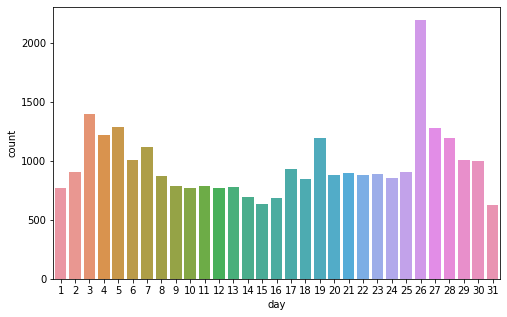

In [21]:
# A Chart to display day when most number of ratings were given.
plt.figure(figsize=(8,5))
ax = sns.countplot(x='day', data=df)

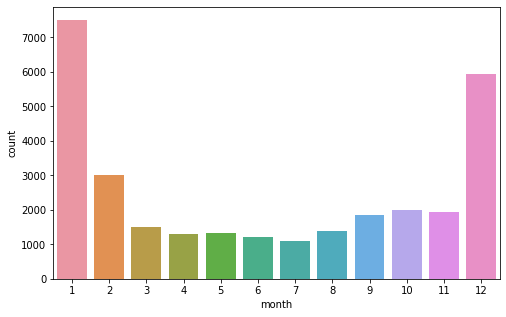

In [22]:
# A Chart to display month when most number of ratings were given.
plt.figure(figsize=(8,5))
ax = sns.countplot(x='month', data=df)

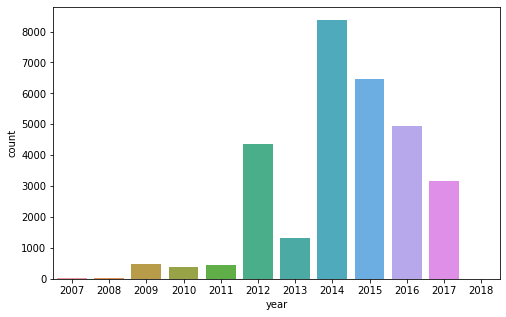

In [23]:
# A Chart to display year when most number of ratings were given.
plt.figure(figsize=(8,5))
ax = sns.countplot(x='year', data=df) 

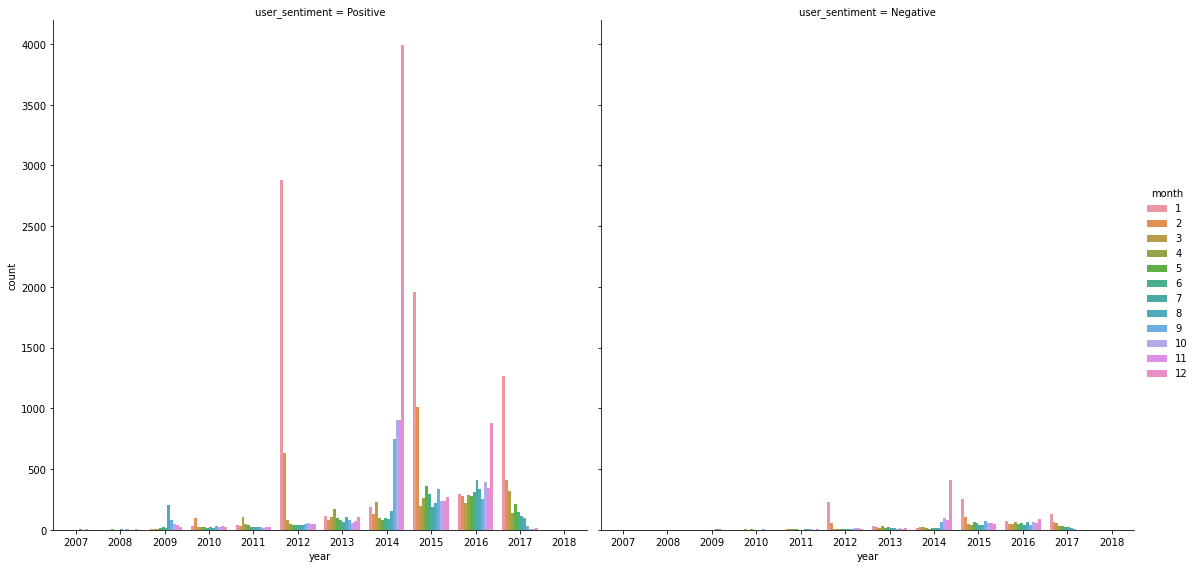

In [24]:
# A chart to display user_sentiment report on the basis of years and month.
g = sns.catplot(x="year", hue="month", col="user_sentiment",
                data=df, kind="count",
                height=8, aspect=1);

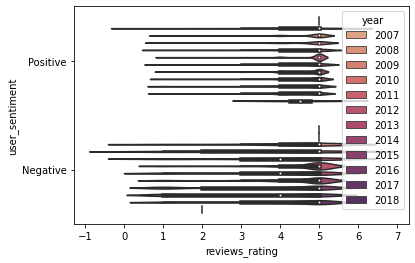

In [25]:
ax = sns.violinplot(data=df, x='reviews_rating', y='user_sentiment', hue='year',  palette='flare')

## **DATA PREPROCESSING**

In [26]:
#Importing more libraries for further use.
import nltk

from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

# Download NLTK packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [27]:
# Lets understand presence of duplicate reviews in dataset by Listing count of duplicate reviews
duplicates = df[df.duplicated(subset={"reviews_username","id"})]
duplicates.reviews_username.value_counts()

byamazon customer    39
mike                 24
chris                19
tony                  7
movielover            6
                     ..
kayet19               1
spidysgirl            1
gissela               1
dkane514              1
filo123               1
Name: reviews_username, Length: 2116, dtype: int64

In [28]:
# Lets take example of User (Reviewer/Shopper) = 'byamazon customer' to look at review data
df[df['reviews_username'] == 'byamazon customer']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_onlydate,day,month,year
16778,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-02-03T00:00:00.000Z,NaN,NaN,1,A waste of my money I don't know what kind of ...,Dyed Rice,NaN,NaN,byamazon customer,Positive,2016-02-03,3,2,2016
16799,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-01-07T00:00:00.000Z,NaN,NaN,4,"Good but if you like it, get it in quantity",Yum,NaN,NaN,byamazon customer,Positive,2017-01-07,7,1,2017
16807,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-08-19T00:00:00.000Z,NaN,NaN,4,RICE LOOKS GOOD.,RICE IS FINE,NaN,NaN,byamazon customer,Positive,2015-08-19,19,8,2015
16812,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-04-08T00:00:00.000Z,NaN,NaN,4,I love the zip lock seal on these bags (unique...,I love the zip lock seal on these bags (unique...,NaN,NaN,byamazon customer,Positive,2015-04-08,8,4,2015
16824,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2011-07-20T00:00:00.000Z,NaN,NaN,4,Lundberg Jubilee is a blend of sweet brown ric...,Beautiful and High-Quality Rice But Too Much S...,NaN,NaN,byamazon customer,Positive,2011-07-20,20,7,2011
16841,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-06-05T00:00:00.000Z,NaN,NaN,5,This takes much longer to cook but the taste i...,Happy,NaN,NaN,byamazon customer,Positive,2017-06-05,5,6,2017
16850,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-04-20T00:00:00.000Z,NaN,NaN,5,Great rice in a small package...I'll be buying...,Recommended,NaN,NaN,byamazon customer,Positive,2017-04-20,20,4,2017
16904,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-07-03T00:00:00.000Z,NaN,NaN,5,Very tasty! Very earthy rice great for breakfa...,Lindberg is just the best!,NaN,NaN,byamazon customer,Positive,2016-07-03,3,7,2016
16920,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-06-23T00:00:00.000Z,NaN,NaN,5,It was great. Very convenient in the 1 lb bags.,Five Stars,NaN,NaN,byamazon customer,Positive,2016-06-23,23,6,2016
16929,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-02-20T00:00:00.000Z,NaN,NaN,5,Good rice.,Five Stars,NaN,NaN,byamazon customer,Positive,2016-02-20,20,2,2016


# **- Inference:**
- User (Reviewer/Shopper) 'byamazon customer' has written multiple reviews at approximately same time.
- Reviews are for same product, same Brand, but different flavors, different review titles, and different ratings
- To avoid confusion this duplication in data causes, we can proceed taking Mean of Ratings for such duplicate reviews thus making data meaningful

In [29]:
# As decided, Take Mean of Ratings

df['avg_ratings'] = df.groupby(['id','reviews_username'])['reviews_rating'].transform('mean')
df['avg_ratings']=df['avg_ratings'].round(2)
df[['id','reviews_username','reviews_rating','avg_ratings']]

,id,reviews_username,reviews_rating,avg_ratings
0,AV13O1A8GV-KLJ3akUyj,joshua,5,5.0
1,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
2,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
3,AV16khLE-jtxr-f38VFn,rebecca,1,1.0
4,AV16khLE-jtxr-f38VFn,walker557,1,1.0
...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,laurasnchz,5,5.0
29996,AVpfW8y_LJeJML437ySW,scarlepadilla,5,5.0
29997,AVpfW8y_LJeJML437ySW,liviasuexo,5,5.0
29998,AVpfW8y_LJeJML437ySW,ktreed95,5,5.0


In [30]:
# Now delete duplicate Reviews for same product ID and User (Reviewer/Shopper)
df_final =  df.drop_duplicates(subset={"reviews_username","id"},keep="first")

In [31]:
# Validate deletion of duplicates for User = 'byamazon customer'
df_final[df_final['reviews_username'] == 'byamazon customer']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_onlydate,day,month,year,avg_ratings
16778,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-02-03T00:00:00.000Z,NaN,NaN,1,A waste of my money I don't know what kind of ...,Dyed Rice,NaN,NaN,byamazon customer,Positive,2016-02-03,3,2,2016,4.58
26450,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2017-07-05T00:00:00.000Z,NaN,NaN,1,"The first time I used in my infant, he rubbed ...",Not Tear Free Not Useful,NaN,NaN,byamazon customer,Positive,2017-07-05,5,7,2017,3.41


In [32]:
# Understand new size of dataset after removal of duplicate Reviews
size_diff = df_final['id'].size/df['id'].size

print("%.f%% reduction in data post duplicate review deletion"%((1-size_diff)*100))
print("Revised size of data = ",df_final['id'].size,"rows ")

8% reduction in data post duplicate review deletion
Revised size of data =  27605 rows 


# **Prepare data for Sentiment Analysis**
- Combining Reviews Title and Reviews Text so as to provide richer sentiment analysis data
- Noise removal - Clean the Review data since its free flowing text, remove Stop words
- Prepare Word Cloud to get a feel for Sentiments via check of frequency of Words in Reviews

Combining the Review Title and Review Text data into a new column

In [33]:
# Combine reviews_title and reviews_text and save as new column "user_reviews"
# Add a period at the end of Review Titles in the new column 
# For Review Title with missing values, adding blank spaces
df_final['reviews_title'] = df_final['reviews_title'].fillna('')
df_final['user_reviews'] = df_final[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [34]:
# Validate output of new column user_reviews
df_final[['reviews_title','reviews_text','user_reviews']].head(5)

,reviews_title,reviews_text,user_reviews
0,Just Awesome,i love this album. it's very good. more to the...,Just Awesome. i love this album. it's very goo...
1,Good,Good flavor. This review was collected as part...,Good. Good flavor. This review was collected a...
3,Disappointed,I read through the reviews on here before look...,Disappointed. I read through the reviews on he...
4,Irritation,My husband bought this gel for us. The gel cau...,Irritation. My husband bought this gel for us....
5,Not worth it,My boyfriend and I bought this to spice things...,Not worth it. My boyfriend and I bought this t...


In [35]:
df_final.shape

(27605, 21)

3.2.2: Noise removal - Cleaning the free flowing Review data

In [36]:
# Removing HTML Tags from Review data
# Defining a Function to remove html tags
# Function structure: 1. Find the pattern and 2. Substitute with nothing

def striphtml(data):
    p = re.compile('<.*?>')
    return p.sub('',data)

In [37]:
# Removing Punctuations from Review data
# Defining a Function to remove All punctuations
# Function structure: 1. Find the pattern and 2. Substitute with nothing

def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)

In [38]:
from nltk.corpus import stopwords

In [39]:
# Initiatilize StopWords

stop = stopwords.words('english')

In [40]:
#from nltk.corpus import snow

ImportError: ignored

In [41]:
pip install snow

     |████████████████████████████████| 47 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 26.5 MB/s 
     |████████████████████████████████| 144 kB 55.1 MB/s 
     |████████████████████████████████| 271 kB 53.4 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 


In [42]:
# Initiatilize StopWords

stop = stopwords.words('english')

In [43]:

snow = SnowballStemmer('english', ignore_stopwords=True)

In [44]:
# Defining a Function for NLTK tags to Wordnet tags

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [45]:
# Defining a Function to tokenize the sentence and determine the POS tag for respective tokens

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged) #tuple of (token, wordnet_tag)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None: #if no available tag, append the token ASIS, else use the tag to lemmatize the token
            lemmatized_sentence.append(snow.stem(word)) #no lemma, stem the word
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag)) #lemmatize the token
    return " ".join(lemmatized_sentence)

In [46]:
# Defining a Function for Pre-processing output

def preprocess_text(text, stem=False): 
 
  text=text.lower()                # transform to lower case
  text = striphtml(text)           # remove HTML Tags using earlier defined function
  text = strippunc(text)           # remove Punctuation using earlier defined function
  return lemmatize_sentence(text)

In [47]:
# Pre-processing the dataset for user_reviews column & creating a 'Review' column which will be used for further analysis
# Additionally removing stop words from the new column - Review

df_main = df_final.copy(deep = True)
df_main['Review'] = df_main['user_reviews'].map(preprocess_text)
df_main['Review'] = df_main['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_main.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,...,reviews_userProvince,reviews_username,user_sentiment,reviews_onlydate,day,month,year,avg_ratings,user_reviews,Review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,...,NaN,joshua,Positive,2012-11-30,30,11,2012,5.0,Just Awesome. i love this album. it's very goo...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,...,NaN,dorothy w,Positive,2017-07-09,9,7,2017,5.0,Good. Good flavor. This review was collected a...,good good flavor review collect part promotion
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,...,NaN,rebecca,Negative,2016-01-06,6,1,2016,1.0,Disappointed. I read through the reviews on he...,disappointed read review look buy one couple l...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,...,NaN,walker557,Negative,2016-12-21,21,12,2016,1.0,Irritation. My husband bought this gel for us....,irritation husband buy gel us gel cause irrita...
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,...,NaN,samantha,Negative,2016-04-20,20,4,2016,1.0,Not worth it. My boyfriend and I bought this t...,worth boyfriend buy spice thing bedroom highly...


In [48]:
# Printing Review column output for first record as a sample to validate

df_main['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy'

#### 3.2.3: Common and Rare Words in Corpus

In [49]:
# Defining a function for plotting Top n Common Words in column

def common_wds(column, terms, title_label):
  all_words_column = ' '.join([text for text in column])
  all_words_column = all_words_column.split()

  fr_dist = FreqDist(all_words_column)
  words_df = pd.DataFrame({'word':list(fr_dist.keys()), 'count':list(fr_dist.values())})

  word_rank = words_df.nlargest(columns="count", n = terms)   # Select Top 20 most frequent words
  plt.figure(figsize=(10,5))
  ax = sns.scatterplot(data=word_rank, x= "count", y = "word", color = "green")
  ax.set(ylabel = 'common words')
  plt.title(title_label, fontsize = 14)
  plt.grid()
  plt.show()

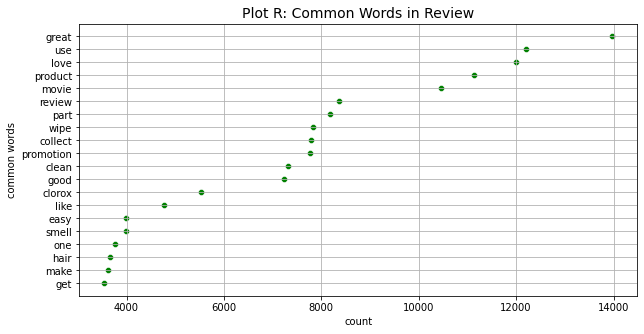

In [50]:
# Plotting Common Words in Review column ranked upto 20

common_wds(df_main['Review'],20,'Plot R: Common Words in Review')

In [51]:
# Defining a Function for plotting least occurring words in column

def rare_wds(column, terms, title_label):
  all_words_column = ' '.join([text for text in column])
  all_words_column = all_words_column.split()

  fr_dist = FreqDist(all_words_column)
  words_df = pd.DataFrame({'word':list(fr_dist.keys()), 'count':list(fr_dist.values())})

  # selecting top 20 most frequent words
  word_rank = words_df.nsmallest(columns="count", n = terms) 
  plt.figure(figsize=(10,5))
  ax = sns.scatterplot(data=word_rank, x= "count", y = "word", color = "green")
  ax.set(ylabel = 'rare words')
  plt.title(title_label, fontsize = 14)
  plt.grid()
  plt.show()

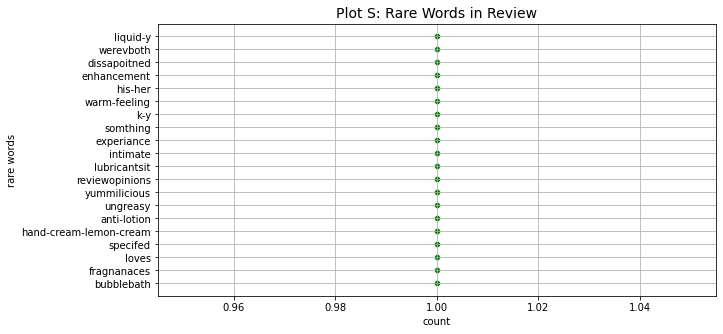

In [52]:
# Plotting Rare Words in Review column ranked upto 20

rare_wds(df_main['Review'],20, 'Plot S: Rare Words in Review')

3.2.3: Average Word Length in Review data

In [53]:
# Defining a Function to measure average word length in Review column

def avg_wd_len(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df_main['Review_avgwdln'] = df_main['Review'].apply(lambda x: avg_wd_len(x))
df_main[['Review_avgwdln','Review']].head(5)

,Review_avgwdln,Review
0,4.850000,awesome love album good hip hop side current p...
1,5.714286,good good flavor review collect part promotion
3,6.137931,disappointed read review look buy one couple l...
4,5.200000,irritation husband buy gel us gel cause irrita...
5,5.727273,worth boyfriend buy spice thing bedroom highly...


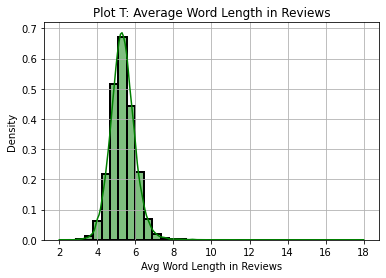

In [54]:
# Plotting Average Word Length

sns.histplot(df_main['Review_avgwdln'], kde=True, stat="density", linewidth=2, bins=int(180/5), color = 'green')
plt.title('Plot T: Average Word Length in Reviews')
plt.xlabel('Avg Word Length in Reviews')
plt.ylabel('Density')
plt.grid()
plt.show()

3.2.3: Word Cloud for Review data
  1. Word Cloud for reviews title
  2. Word Cloud for reviews text
  3. Word Cloud for Review (that includes both title and text)

In [55]:
# Defining a function to deliver Word CLouds

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from matplotlib import pyplot as plt

def display_wc(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random with a coin flip
).generate(str(data))

    fig = plt.figure(1, figsize=(10, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.5)

    plt.imshow(wordcloud)
    plt.show()

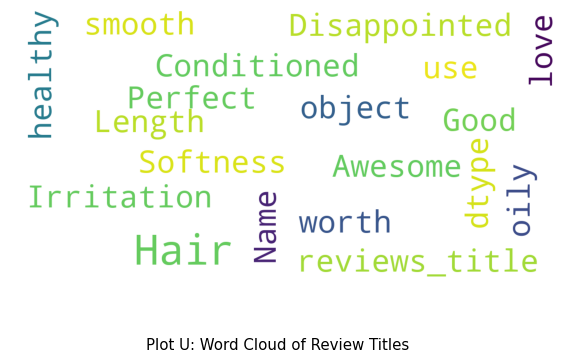

In [56]:
# Word Cloud for reviews title

display_wc(df_final['reviews_title'],'Plot U: Word Cloud of Review Titles')

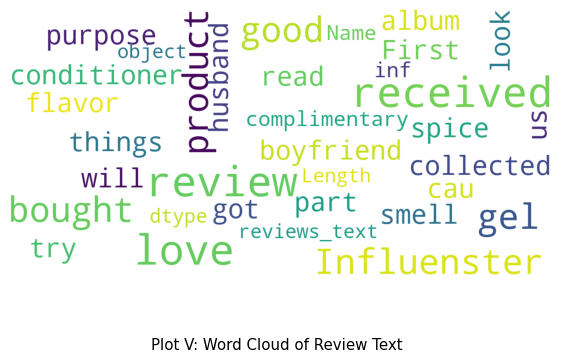

In [57]:
# Word Cloud for reviews text

display_wc(df_final['reviews_text'],'Plot V: Word Cloud of Review Text')

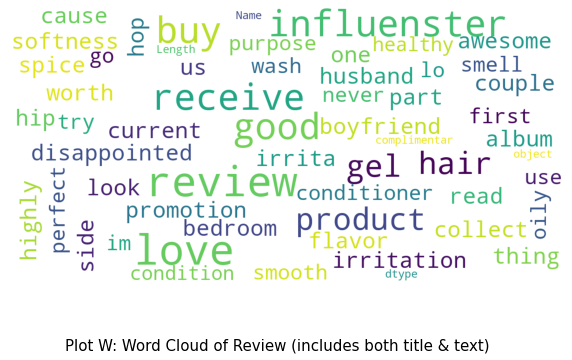

In [58]:
# Word Cloud for Review - that includes both title and text

display_wc(df_main['Review'], 'Plot W: Word Cloud of Review (includes both title & text)')

4. Sentiment Analysis

In [59]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from xgboost import XGBClassifier

In [60]:
# Cleaning data frame dropping irrelevant data

df_main=df_main[['Review','reviews_rating','user_sentiment']]
data=df_main
df_main.head()

,Review,reviews_rating,user_sentiment
0,awesome love album good hip hop side current p...,5,Positive
1,good good flavor review collect part promotion,5,Positive
3,disappointed read review look buy one couple l...,1,Negative
4,irritation husband buy gel us gel cause irrita...,1,Negative
5,worth boyfriend buy spice thing bedroom highly...,1,Negative


In [61]:
#Size of data frame:

df_main.shape

(27605, 3)

In [62]:
# Basic check for unique values and missing data values

print("Unique data values in data frame:")
df_main.nunique(axis=0)

Unique data values in data frame:


Review            26753
reviews_rating        5
user_sentiment        2
dtype: int64

In [63]:
# Save data for later usage

import pickle as pickle
pickle.dump(data, open("data.pkl","wb"))

In [64]:
from pathlib import Path
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_vectorizer.fit(data['Review'])
X = tfidf_vectorizer.transform(data['Review'])
y = data['user_sentiment']

# Saving the vocabulary used in tfidf vectorizer as features
pickle.dump(tfidf_vectorizer.vocabulary_, open("features.pkl","wb"))

# Split train test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [65]:
### Class Imbalance check and method to handle it
data.groupby(['user_sentiment']).count()

,Review,reviews_rating
user_sentiment,,
Negative,3058,3058
Positive,24547,24547


Note:
a. It appears we have imbalanced training data set
b. However considering we have valid sentiment data in user_sentiment column (and the data quality is very good for this colum), the dataset is valid and we will continue with the dataset. There is no need to do use oversampling or undersampling techniques.

5. Scoring of Classifiers

In [66]:
# Defining a Function to calculate confusion matrix and display scores for various ML models

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

def display_model_score(classifier):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    plot_confusion_matrix(classifier, X_test, y_test,include_values=True,values_format='g',cmap=plt.cm.Greens) 
    p_acc = float(accuracy_score(y_test, classifier.predict(X_test)))
    p_sen = float(format(cm[1][1]/sum(cm[1])))
    p_spe = float(format(cm[0][0]/sum(cm[0])))
    p_pre = float(format(cm[1][1]/((cm[1][1])+(cm[0][1]))))
    p_f1s = float(format(2*cm[1][1]/(((cm[1][1])+(cm[0][1]))+sum(cm[1]))))
    print(classifier)
    print('\n')
    print(f"Accuracy is {p_acc:.4f}")
    print(f"Sensitivity is {p_sen:.4f}")
    print(f"Specificity is {p_spe:.4f}")
    print(f"Precision is {p_pre:.4f}")
    print(f"F1 Score is {p_f1s:.4f}")
    return p_acc, p_sen, p_spe, p_pre, p_f1s

6. Evaluating the model choices

- Build multiple Machine Learning models among below 4 taking class imbalance and hyperparameter tuning into consideration:  
&emsp;1. Logistic Regression  
&emsp;2. Random Forest  
&emsp;3. XGBoost  
&emsp;4. Naive Bayes  
- Analyse the performance of each of the models
- Confirm the best fit model 

In [67]:
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS


6.1: ML Model 1 - Logistic Regression

In [68]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    cm = confusion_matrix(y_test, lr.predict(X_test))
    print('Sensitivity for C = {0} is {1}'.format(c, cm[1][1]/sum(cm[1])))
    print('Specificity for C = {0} is {1}'.format(c, cm[0][0]/sum(cm[0])))
    print('Precision for C = {0} is {1}'.format(c, cm[1][1]/((cm[1][1])+(cm[0][1]))))

Sensitivity for C = 0.01 is 1.0
Specificity for C = 0.01 is 0.0
Precision for C = 0.01 is 0.887568820631701
Sensitivity for C = 0.05 is 1.0
Specificity for C = 0.05 is 0.0
Precision for C = 0.05 is 0.887568820631701
Sensitivity for C = 0.25 is 0.9998367613450865
Specificity for C = 0.25 is 0.0
Precision for C = 0.25 is 0.8875525286190408
Sensitivity for C = 0.5 is 0.9996735226901731
Specificity for C = 0.5 is 0.00902061855670103
Precision for C = 0.5 is 0.888437545335848
Sensitivity for C = 1 is 0.9990205680705191
Specificity for C = 1 is 0.037371134020618556
Precision for C = 1 is 0.891218872870249


In [69]:
final_lr = LogisticRegression(C=0.05)
final_lr.fit(X_train, y_train)

LogisticRegression(C=0.05)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


LogisticRegression(C=0.05)


Accuracy is 0.8876
Sensitivity is 1.0000
Specificity is 0.0000
Precision is 0.8876
F1 Score is 0.9404


(0.887568820631701, 1.0, 0.0, 0.887568820631701, 0.9404359840343874)

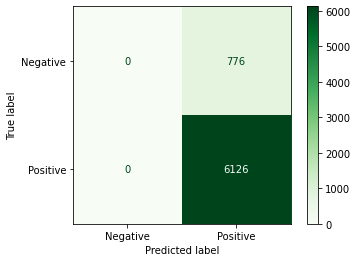

In [70]:
df_lr = display_model_score(final_lr)
df_lr

In [71]:
# saving the model - Logistic Regression
pickle.dump(final_lr, open('logistic_regression_model.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf.pkl", "wb"))

In [72]:
feature_to_coef = {
    word: coef for word, coef in zip(
     tfidf_vectorizer.get_feature_names(), final_lr.coef_[0])
}

print('Positive Words')
for best_positive in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1],
    reverse=True)[:10]:
    print(best_positive)
    
print('Negative Words')
for best_negative in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1])[:10]:
    print(best_negative)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Positive Words
('great', 1.7397102258727615)
('love', 1.3921581326969588)
('good', 1.0367815548129038)
('clean', 0.9916200321825879)
('easy', 0.8635136470891702)
('best', 0.6198408230477508)
('movie', 0.6103836705388999)
('awesome', 0.46090223486551946)
('easy use', 0.4572391166039365)
('smell', 0.4402094017544527)
Negative Words
('bad', -0.7494508620722207)
('formula', -0.4804742967304338)
('evil', -0.44837658609026704)
('resident evil', -0.4031389191779773)
('resident', -0.402188820345563)
('gel', -0.39543924742277087)
('horrible', -0.37842637109907223)
('disappointed', -0.35429337186663595)
('sick', -0.34521753883226003)
('terrible', -0.323304026948554)


6.2: ML Model 2 - Random Forest Classifier (without hyperparameter tuning and with hyperparameter tuning)

In [73]:
# Random Forest classifier without any hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV
final_rf = RandomForestClassifier()
final_rf.fit(X_train, y_train)

RandomForestClassifier()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifier()


Accuracy is 0.8932
Sensitivity is 0.9992
Specificity is 0.0567
Precision is 0.8932
F1 Score is 0.9432


(0.8932193567082005,
 0.9991838067254326,
 0.05670103092783505,
 0.893185466219174,
 0.9432159642499423)

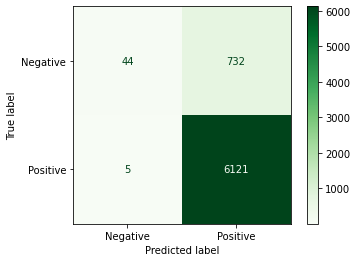

In [74]:
df_rf = display_model_score(final_rf)
df_rf

In [75]:
# saving the model - Random Forest
pickle.dump(final_rf, open('random_forest_model.pkl', 'wb'))

In [76]:
# Random Forest classifier with various hyperparameters
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [15, 20],
    'min_samples_leaf': [100,200],
    'min_samples_split': [200,400],
    'n_estimators': [100, 300]
}

# Create a based model
final_rft = RandomForestClassifier()

# Instantiate the grid search model
rf_tuned = GridSearchCV(estimator = final_rft, param_grid = param_grid, scoring='roc_auc', cv = 3, n_jobs = -1,verbose = 1)
rf_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)

In [77]:
# Print best hyperparameters

print("Best AUC-ROC Score on train data: ", rf_tuned.best_score_)
print("Best hyperparameters: ", rf_tuned.best_params_)

Best AUC-ROC Score on train data:  0.7512076500273984
Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 100, 'min_samples_split': 400, 'n_estimators': 300}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)


Accuracy is 0.8876
Sensitivity is 1.0000
Specificity is 0.0000
Precision is 0.8876
F1 Score is 0.9404


(0.887568820631701, 1.0, 0.0, 0.887568820631701, 0.9404359840343874)

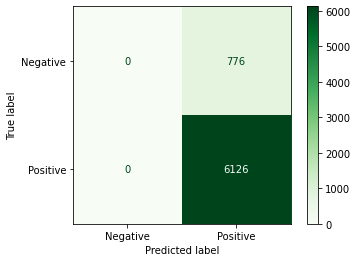

In [78]:
# Test data performance metrics
df_rft = display_model_score(rf_tuned)
df_rft

In [79]:
# saving the model - Random Forest with Hyperparameter Tuning

pickle.dump(rf_tuned, open('random_forest_tuned_model.pkl', 'wb'))

6.3: ML Model 3 - Naive Bayes

In [80]:
# Fitting Naive Bayes Model

nb=MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

MultinomialNB()


Accuracy is 0.8876
Sensitivity is 1.0000
Specificity is 0.0000
Precision is 0.8876
F1 Score is 0.9404


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


(0.887568820631701, 1.0, 0.0, 0.887568820631701, 0.9404359840343874)

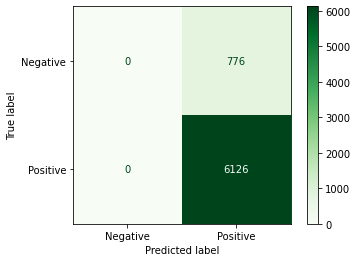

In [81]:
# Test Data Performance Metrics

df_nb = display_model_score(nb)
df_nb

In [82]:
# saving the model - Naive Bayes

pickle.dump(nb, open('naive_bayes_model.pkl', 'wb'))

6.4: ML Model 4 - XGBoost Classifier (without hyperparameter tuning and with hyperparameter tuning)

In [83]:
# XGBoost classifier without any hyperparameter tuning

final_xgb = XGBClassifier(booster='gbtree')
final_xgb.fit(X_train, y_train)

XGBClassifier()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


XGBClassifier()


Accuracy is 0.8942
Sensitivity is 0.9976
Specificity is 0.0786
Precision is 0.8953
F1 Score is 0.9436


(0.894233555491162,
 0.9975514201762977,
 0.07860824742268041,
 0.8952534427190155,
 0.9436380481778875)

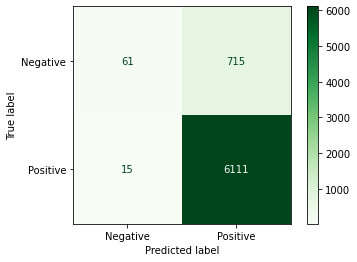

In [84]:
# Displaying Confusion matrix Scores

#Test data performance metrics
df_xgb = display_model_score(final_xgb)
df_xgb

In [85]:
# saving the model - XGBoost

pickle.dump(final_xgb, open('xgboost_model.pkl', 'wb'))

In [86]:
# XGBoost classifier with various custom hyperparameters

param_grid = {'learning_rate': [0.001, 0.01], 'max_depth':[ 5, 10],  'n_estimators':[1, 3]}

final_xgb = XGBClassifier(booster='gbtree')

# set up GridSearchCV()
xgb_tuned = GridSearchCV(estimator = final_xgb, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv =3, 
                        verbose = 1,
                        return_train_score=True)

xgb_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [5, 10],
                         'n_estimators': [1, 3]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [87]:
# print best hyperparameters
print("Best AUC-ROC Score on train data: ", xgb_tuned.best_score_)
print("Best hyperparameters: ", xgb_tuned.best_params_)

Best AUC-ROC Score on train data:  0.7602237509245504
Best hyperparameters:  {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 3}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [5, 10],
                         'n_estimators': [1, 3]},
             return_train_score=True, scoring='roc_auc', verbose=1)


Accuracy is 0.8871
Sensitivity is 0.9882
Specificity is 0.0889
Precision is 0.8954
F1 Score is 0.9396


(0.8871341640104318,
 0.9882468168462292,
 0.08891752577319588,
 0.895429670167135,
 0.939551485993637)

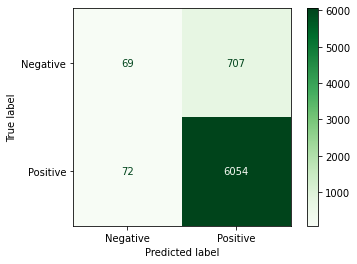

In [88]:
# Displaying Confusion matrix Scores

# Test data performance metrics
df_xgbt = display_model_score(xgb_tuned)
df_xgbt

In [89]:
# saving the model - XGBoost with Hyperparameter Tuning

pickle.dump(xgb_tuned, open('xgboost_tuned_model.pkl', 'wb'))

6.5 Models Comparison

In [90]:
# Index: 0=Accuracy, 1=Sensitivity, 2=Specificity, 3=Precision, 4=F1Score

results = {('LR'):[df_lr[0],df_lr[1],df_lr[2],df_lr[3],df_lr[4]],
           ('NB'):[df_nb[0],df_nb[1],df_nb[2],df_nb[3],df_nb[4]],
           ('XGB'):[df_xgb[0],df_xgb[1],df_xgb[2],df_xgb[3],df_xgb[4]],
           ('XGB Tuned'):[df_xgbt[0],df_xgbt[1],df_xgbt[2],df_xgbt[3],df_xgbt[4]],
           ('RF'):[df_rf[0],df_rf[1],df_rf[2],df_rf[3],df_rf[4]],
           ('RF Tuned'):[df_rft[0],df_rft[1],df_rft[2],df_rft[3],df_rft[4]]
          }
pd.DataFrame(results, index=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1Score'])

,LR,NB,XGB,XGB Tuned,RF,RF Tuned
Accuracy,0.887569,0.887569,0.894234,0.887134,0.893219,0.887569
Sensitivity,1.000000,1.000000,0.997551,0.988247,0.999184,1.000000
Specificity,0.000000,0.000000,0.078608,0.088918,0.056701,0.000000
Precision,0.887569,0.887569,0.895253,0.895430,0.893185,0.887569
F1Score,0.940436,0.940436,0.943638,0.939551,0.943216,0.940436


##### Score driving the model choice:
- Considering the user sentiment data - <i> in user_sentiment column in the sample30.csv dataset</i> - is unambiguous and of high quality, we will look at Accuracy, Precision, and F1Score in choosing our bext model as these are strongly driven on True Positive data.
- While Sensitivity and Specificity do provide good results, here in our case we can ignore these as the sentiment data is high quality and there is less play for True Negative OR False Negative dataset.

##### Observations on above Scores:
- XGBoost has the best Accuracy and F1Score 
- Random Forest has the next best Accuracy and F1Score

##### Inference:
- XGBoost without any hyperparameter tuning is the best model
- Random Forest without any hyperparameter tuning is the next best model 

In [91]:
import pickle
# Based on above execution, save the best trained model as a pickle string, saving next best model also - just in case

saved_model = pickle.dump(final_xgb, open('xgboost_model.pkl', 'wb'))
saved_model_2 = pickle.dump(final_rf, open('random_forest_model.pkl', 'wb'))

In [91]:
/content/data.pkl

### 7: Building Recommendation System 
- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation
Different Approaches to develop Recommendation System -

1. Demographic based Recommendation System
2. Content Based Recommendation System
3. Collaborative filtering Recommendation System

In [92]:
# Importing Libraries

from sklearn.metrics.pairwise import pairwise_distances

In [93]:
ratings=df[['id', 'reviews_rating', 'reviews_username']]


In [94]:
# Checking for null values

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_username  29937 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [95]:
ratings = ratings[~ratings.reviews_username.isna()]
ratings.columns=['productId', 'rating', 'user']
ratings.head()

,productId,rating,user
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
3,AV16khLE-jtxr-f38VFn,1,rebecca
4,AV16khLE-jtxr-f38VFn,1,walker557


7.1: Splitting the dataset into train and test
# Test and Train split of the dataset

In [96]:
# Test and Train split of the dataset

from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state=12)

print(train.shape)
print(test.shape)

(20955, 3)
(8982, 3)


In [97]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user IDs.

df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).fillna(0)

df_pivot.head(3)

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


7.2 : Creating dummy train & dummy test dataset
These dataset will be used for prediction:

Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [98]:
# Copy the train dataset into dummy_train

dummy_train = train.copy()

dummy_train.head()

,productId,rating,user
27729,AVpfRTh1ilAPnD_xYic2,5,stevieboy23
17120,AVpf9pzn1cnluZ0-uNTM,5,byo.kelly
22028,AVpfnRuSilAPnD_xfB8l,3,linda h
16308,AVpf63aJLJeJML43F__Q,5,cocoacrazy
19457,AVpfJP1C1cnluZ0-e3Xy,5,vanessavast


In [99]:
# The products not rated by user is marked as 1 for prediction. 

dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [100]:
# Convert the dummy train dataset into matrix format.

dummy_train = dummy_train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).fillna(1)


dummy_train.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### 7.3: User Cosine Similarity Matrix
- Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

In [101]:
df_pivot.index.nunique()

18188

In [102]:
# User Similarity Matrix via pairwise_distance function

user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [103]:
user_correlation.shape

(18188, 18188)

#### 7.4: Using Adjusted Cosine
- Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes
- In other words, some users might rate items highly in general, and others might give items lower ratings as a preference
- To handle this nature from rating given by user, we can subtract average ratings for each user from each user's rating for different products

##### Note: In this case we are not removing the NaN values and calculating the mean only for the products rated by the user

In [104]:
# Create a user-product matrix.

df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
)

In [105]:
df_pivot.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


7.5: Normalising the rating of the products for each user around 0 mean

In [106]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


7.6: Finding Cosine Similarity

In [107]:
# Creating the User Similarity Matrix using pairwise_distance function.

user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [108]:
user_correlation.shape

(18188, 18188)

#### 7.7: Prediction - User User
- Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [109]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).  Calculating User predicted ratings. 

In [110]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.93649167,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [111]:
user_predicted_ratings.shape

(18188, 251)

In [112]:
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.93649167,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

##### Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by setting it to zero. 

In [113]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


##### Calculating the Top 20 Recommendations for the <i>user</i>

In [114]:
user_final_rating

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
zxcsdfd,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
zyiah4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [115]:
# Take the user ID as input
#user_input = input("Enter your user name") #2athome

user_input='2athome'
print(user_input)


2athome


In [116]:
user_final_rating.head(10)

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.000000,0.000000,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
08dallas,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1.11E+24,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
10ten,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
11111111aaaaaaaaaaaaaaaaa,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [117]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

productId
AV14LG0R-jtxr-f38QfS    0.0
AVpfPPkEilAPnD_xX3cP    0.0
AVpfN6Z71cnluZ0-gZmO    0.0
AVpfNVsj1cnluZ0-gNQN    0.0
AVpfNWbPilAPnD_xXPR7    0.0
AVpfNc9cLJeJML434tza    0.0
AVpfNfEMLJeJML434uf-    0.0
AVpfNglu1cnluZ0-gQ7x    0.0
AVpfO5u71cnluZ0-guiN    0.0
AVpfOIrkilAPnD_xXgDG    0.0
AVpfOfIqLJeJML435D06    0.0
AVpfOmKwLJeJML435GM7    0.0
AVpfOrD0ilAPnD_xXrRj    0.0
AVpfP-rELJeJML435jEN    0.0
AVpfPKzxLJeJML435SYL    0.0
AVpfPaoqLJeJML435Xk9    0.0
AVpfSvmGilAPnD_xY_gE    0.0
AVpfPjqKLJeJML435aZR    0.0
AVpfPkrkilAPnD_xX-L9    0.0
AVpfPnrU1cnluZ0-g9rL    0.0
Name: 2athome, dtype: float64

#### 7.8: Evaluation - User User 

##### Item Based Similarity
- Taking the transpose of the rating matrix to normalize the rating around the mean for different products ID. In the user based similarity, we had taken mean for each user instead of each products.

In [118]:
df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).T

df_pivot.head()

user,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zyiah4,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Normalising the Product rating for each product for using the Adujsted Cosine

In [119]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

user,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zyiah4,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Finding the Cosine Similarity using pairwise distances approach

In [120]:
from sklearn.metrics.pairwise import pairwise_distances

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)
print(item_correlation.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(251, 251)


##### Filtering for positive correlation - only for which the value is greater than 0

In [121]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### 7.9: Prediction - Item Item

In [122]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00666715, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00693369],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00554695]])

In [123]:
item_predicted_ratings.shape

(18188, 251)

In [124]:
dummy_train.shape

(18188, 251)

##### Filtering the rating only for the products not rated by the user for recommendation

In [125]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.006364,0.0,0.000000,...,0.0,0.014313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.006667,0.0,0.0,0.0,0.0,0.004563,0.000000,0.0,0.000896,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.011112,0.0,0.0,0.0,0.0,0.007606,0.000000,0.0,0.001493,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.008890,0.0,0.0,0.0,0.0,0.006084,0.000000,0.0,0.001195,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Calculating the Top 20 recommendation for the <i>user</i>

In [126]:
# Take the user ID as input
#user_input = input("Enter your user name")
user_input='44pam44'
print(user_input)

44pam44


In [127]:
# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

productId
AVpfJP1C1cnluZ0-e3Xy    0.977287
AVpfW8y_LJeJML437ySW    0.020768
AVpfTVkcilAPnD_xZLts    0.013471
AVpfluP1ilAPnD_xejxO    0.011236
AVpe6FfKilAPnD_xQmHi    0.007860
AVpfvieo1cnluZ0-qdnu    0.006934
AVpfBO2vLJeJML430mGh    0.005616
AVpe_N91LJeJML43z4jD    0.005572
AVpfRTh1ilAPnD_xYic2    0.004840
AVpf2tw1ilAPnD_xjflC    0.004746
AVpfrfHF1cnluZ0-pRai    0.004316
AVpf9_3MLJeJML43GvdB    0.004271
AVpfD9xTLJeJML431ig2    0.004171
AVpe6n2_LJeJML43yOgE    0.003930
AVpe8gsILJeJML43y6Ed    0.003771
AVpf0YhQLJeJML43ETff    0.003444
AVpfcu821cnluZ0-k8ep    0.003363
AVpe59io1cnluZ0-ZgDU    0.003353
AVpf5FF71cnluZ0-tHAV    0.003183
AVpf5olc1cnluZ0-tPrO    0.002896
Name: 44pam44, dtype: float64

In [128]:
# saving the model
pickle.dump(user_final_rating.astype('float32'), open('user_final_rating.pkl', 'wb'))

#### 7.10 Evaluation - Item Item
- Same Evaluation as for the prediction. Except that it will be evaluated for the products already rated by the User instead of predicting it for the products not rated by the User

In [129]:
test.columns

Index(['productId', 'rating', 'user'], dtype='object')

In [130]:
common =  test[test.productId.isin(train.productId)]
common.shape

(8962, 3)

In [131]:
common.head(4)

,productId,rating,user
19513,AVpfJP1C1cnluZ0-e3Xy,5,kanderson927
12599,AVpf3VOfilAPnD_xjpun,5,arib
1587,AVpe31o71cnluZ0-YrSD,4,karv
15380,AVpf5FF71cnluZ0-tHAV,5,xxacw12xx


In [132]:
common_item_based_matrix = common.pivot_table(index='user', columns='productId', values='rating').T

In [133]:
common_item_based_matrix.shape

(199, 8383)

In [134]:
item_correlation_df = pd.DataFrame(item_correlation)

In [135]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
item_correlation_df['productId'] = df_subtracted.index
item_correlation_df.set_index('productId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
list_name = common.productId.tolist()

In [138]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [139]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [140]:
item_correlation_df_3.head()

,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.037657,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.066184,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07508529, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00693369, 0.00693369, 0.01091379, ..., 0.        , 0.00693369,
        0.00277348]])

In [142]:
common_item_predicted_ratings.shape

(199, 8383)

##### Dummy Test for evaluation
- Dummy test to be used for evaluation.
- To evaluate, we will only make prediction on the products rated by the user. Thus this is marked as 1. This is just opposite of dummy_train.
- The products not rated is marked as 0 for evaluation. And make the item-item matrix representaion.

In [143]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='productId', values='rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [144]:
common_ = common.pivot_table(index='user', columns='productId', values='rating').T

In [145]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [146]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [147]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5

print(f"rmse is {rmse:.4f}")

rmse is 3.5462


In [148]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.546247156875943
